In [1]:
import pandas as pd
from pathlib import Path # type: ignore
from freyja_plot import FreyjaPlotter
from scipy.spatial.distance import pdist, squareform
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sys
if (module_path:=str(Path(".").absolute().resolve().parent)) not in sys.path:
    sys.path.insert(0, module_path)
from sample_info import renameSamples, summary_dict, expected, platforms, platform_renames, backgrounds, get_freyja_aggregate_file

In [2]:
file_map = {}
for platform in platforms:
    for background in backgrounds:
        file_map[str(get_freyja_aggregate_file(platform, background))] = f"{platform_renames[platform]}: {background.upper()}"
file_map[str(expected)] = "Expected"
plotter = FreyjaPlotter(file_map=file_map,summary_dict=summary_dict)
plotter = renameSamples(plotter)
df = plotter.freyja_df.rename(columns={"Sample name":"sample","abundances":"abundance","scheme":"batch","lineages":"lineage"})
df

,sample,lineage,abundance,batch
654,0,B,0.332806,Illumina (unpaired): WB
7371,0,B.10,0.001653,ONT: NWRB
7370,0,B.3.1,0.002402,ONT: NWRB
7369,0,B.27,0.004283,ONT: NWRB
7368,0,B.20,0.322613,ONT: NWRB
...,...,...,...,...
6326,o5-3,BA.5.5,0.998521,CG: PWRB
3084,o5-3,BA.5.5,0.999747,Illumina (minimap2): PWRB
6327,o5-3,BA.5.5.1,0.001479,CG: PWRB
8105,o5-3,BA.5.5,0.978132,ONT: PWRB


In [3]:
lineages = set(df["lineage"].unique())
l2_batches = set(df["batch"].unique())
l2s = []

# for each sample, calculate l2 array for the batches
for sample in set(df["sample"].unique()) - {None}:
    sample_df = df.loc[df['sample'] == sample, ('batch', 'lineage', 'abundance')]
    # print(sample_df)
    
    pivoted_sample_df = sample_df.pivot_table(index='lineage', columns='batch', values='abundance').fillna(0).T
    # print(pivoted_sample_df)

    # for any missing batch, append 0-abundance df to bottom
    dfs2append = []
    missing_batches = l2_batches - set(pivoted_sample_df.index.unique())
    # print(f"{sample} missing batches: {missing_batches}")
    for batch in missing_batches:
        dfs2append.append(
            pd.DataFrame({lin:[0] for lin in lineages},index=[batch])
        )
    if dfs2append:
        pivoted_sample_df = pd.concat([pivoted_sample_df]+dfs2append).fillna(0)
    pivoted_sample_df = pivoted_sample_df.reindex(["Expected"] + [x for x in pivoted_sample_df.index if x != "Expected"])

    Y = squareform(pdist(pivoted_sample_df, 'euclidean'))
    l2s.append(Y)

# get order of batches, as they appear in the l2s
l2_index = pivoted_sample_df.index

# combine l2 results into a single condensed array
l2s_stacked = np.stack(l2s)
l2m = np.median(l2s_stacked, axis=0)
l2m

array([[0.00000000e+00, 8.16518376e-01, 8.16496723e-01, 8.16509978e-01,
        8.16916735e-01, 8.16592927e-01, 9.79795917e-01, 8.16916735e-01,
        8.20040663e-01, 9.68358067e-01, 8.16499206e-01, 8.16496620e-01,
        8.16504528e-01, 8.16571747e-01, 8.16715755e-01, 7.07197419e-01],
       [8.16518376e-01, 0.00000000e+00, 3.13588390e-02, 1.10885383e-01,
        2.40852121e-01, 4.48914098e-01, 5.95104102e-01, 2.33739174e-01,
        3.29955794e-01, 3.96077253e-01, 2.50128925e-02, 1.33635070e-01,
        2.42309999e-01, 3.56531991e-01, 4.53778007e-01, 4.75577244e-01],
       [8.16496723e-01, 3.13588390e-02, 0.00000000e+00, 1.37365687e-01,
        2.70365922e-01, 4.81588974e-01, 5.76647017e-01, 2.48952626e-01,
        4.19844242e-01, 4.07239689e-01, 3.47218539e-02, 1.64458804e-02,
        2.94662632e-01, 4.01066233e-01, 4.20017094e-01, 5.11930257e-01],
       [8.16509978e-01, 1.10885383e-01, 1.37365687e-01, 0.00000000e+00,
        4.43832780e-01, 5.44263489e-01, 5.46112580e-01, 4.007

In [4]:
len(file_map)

16

In [6]:
expected_vs_batches = list(l2m[0])
# if len(set(expected_vs_batches)) < len(expected_vs_batches):
#     print(expected_vs_batches)
#     raise Exception("Can't sort things when any values are duplicated")
idx = [expected_vs_batches.index(x) for x in sorted(expected_vs_batches)]
l2m_clustered = l2m[idx,:]
l2m_clustered = l2m_clustered[:,idx]
l2m_clustered

array([[0.00000000e+00, 7.07197419e-01, 8.16496620e-01, 8.16496723e-01,
        8.16499206e-01, 8.16504528e-01, 8.16509978e-01, 8.16518376e-01,
        8.16571747e-01, 8.16592927e-01, 8.16715755e-01, 8.16916735e-01,
        8.16916735e-01, 8.20040663e-01, 9.68358067e-01, 9.79795917e-01],
       [7.07197419e-01, 0.00000000e+00, 4.68405702e-01, 5.11930257e-01,
        4.26014255e-01, 5.28978640e-01, 5.28885429e-01, 4.75577244e-01,
        1.31546350e-01, 4.45681745e-01, 6.68506001e-02, 4.02283044e-01,
        4.02283044e-01, 4.31891234e-01, 6.96957242e-01, 6.40342279e-01],
       [8.16496620e-01, 4.68405702e-01, 0.00000000e+00, 1.64458804e-02,
        8.04344504e-02, 1.97363327e-01, 1.81441212e-01, 1.33635070e-01,
        3.82255725e-01, 5.04210719e-01, 4.27642936e-01, 2.56882303e-01,
        2.56882303e-01, 4.78660437e-01, 4.95300115e-01, 5.75426026e-01],
       [8.16496723e-01, 5.11930257e-01, 1.64458804e-02, 0.00000000e+00,
        3.47218539e-02, 2.94662632e-01, 1.37365687e-01, 3.135

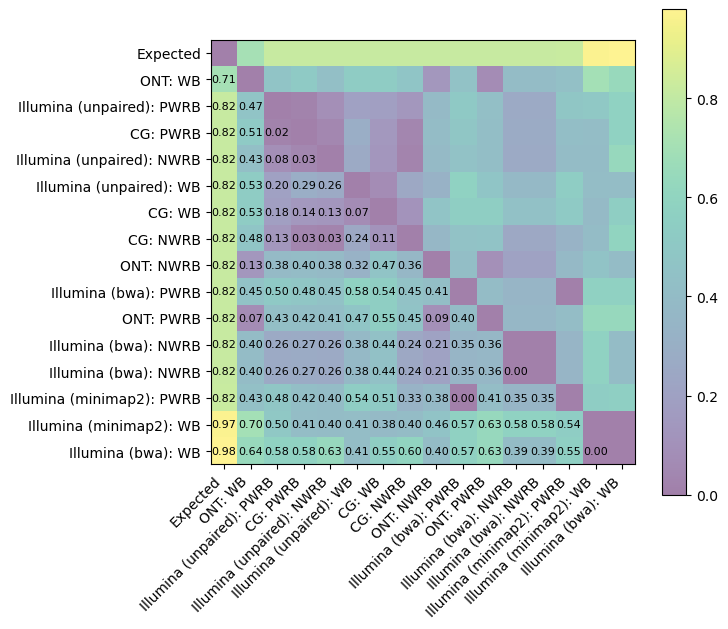

In [7]:
# plot
fig, (ax) = plt.subplots(1, 1, figsize=(6.85, 9))

N = len(l2_index)

ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)

for (j,i), label in np.ndenumerate(l2m_clustered):
    if j > i:
        ax.text(i, j,'{:.2f}'.format(label), ha='center', va='center', fontsize=8)

cmap = matplotlib.colormaps.get_cmap('viridis') # jet doesn't have white color
cmap.set_bad('w') # default value is 'k'

im = ax.imshow(l2m_clustered, alpha=0.5, cmap=cmap, aspect='equal')
fig.colorbar(im, ax=ax, shrink=0.7)

ax.set_xticks(np.arange(N))
ax.set_yticks(np.arange(N))
ax.set_xticklabels(l2_index[idx], rotation=45, ha='right')
ax.set_yticklabels(l2_index[idx])

fig.savefig('L2_matrix_specific_artic.tiff', dpi=600, bbox_inches='tight')
fig.savefig('L2_matrix_specific_artic.png', bbox_inches='tight')